<a href="https://colab.research.google.com/github/manojyadav27/Project_ML/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import sys
#outputFilePath = '/content/drive/MyDrive/ML_Assignment1_Data/output.txt'
path = '/content/drive/MyDrive/ML_Project/'
#outputFile = open(outputFilePath, "w")
#original_stdout = sys.stdout
#sys.stdout = outputFile
randomSeed = 13
from sklearn.model_selection import train_test_split

In [3]:
def add_intercept(X):
    """
    Return X with a leading column of ones (bias term).
    X: (n_samples, n_features) -> (n_samples, n_features + 1)
    Notes: ensure float dtype; do not modify X in-place.
    """
    localObject = X
    rowSize, columnSize = localObject.shape
    leadingOnes = np.full((rowSize, 1), 1, dtype=float)
    modifiedData = np.column_stack((leadingOnes, localObject))
    return modifiedData

In [4]:
def standardize_fit(X_train, eps=1e-12):
    """
    Standardize TRAIN features to zero mean / unit variance.
    Return (Xs, mean, std). Use only TRAIN stats.
    """
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    Xs = (X_train - mean)/std
    return Xs, mean, std

In [5]:
def standardize_apply(X, mean, std, eps=1e-12):
    """
    Apply TRAIN (mean, std) to any new matrix X.
    Do not recompute mean/std here.
    """
    return (X - mean)/std

In [6]:
import random
import math
def train_test_split_idx(n, test_size, seed=0):
    """
    Return (train_idx, test_idx) with fixed RNG.
    You may also use sklearn’s splitter to obtain indices only.
    """
    random.seed(seed)
    train_idx = np.arange(n)
    test_idx = random.sample(train_idx.tolist(), math.floor(n*test_size))
    for id in test_idx:
        train_idx = np.delete(train_idx, id)
    return np.random.shuffle(train_idx), test_idx

end of utility and start of MLE

In [7]:
def mse(y, yhat):
    """Mean squared error: average of (y - yhat)^2 (1D arrays)."""
    temp = y-yhat
    return (temp.T @ temp)/len(y)

In [8]:
def r2_score(y, yhat):
    """1 - SS_res/SS_tot; handle constant-y edge case safely."""
    mean = np.mean(y)
    ssRes = len(y)*mse(y, yhat)
    ssTotTemp = y-mean
    return (1-(ssRes/(ssTotTemp.T @ ssTotTemp)))

In [9]:
def fit_linear_closed_form(X, y, ridge_param = 1.0, add_bias=True, rcond=None):
    """
    Closed-form least squares (MLE) using pseudoinverse or solve.
    Steps:
      * If add_bias: prepend ones.
      * Prefer pinv for numerical stability when X^T X is ill-conditioned.
    Return w (length p [+1 if bias]).
    """
    x = X
    print('shape of data at closed form = ', x.shape)
    if add_bias == True:
        x = add_intercept(X)
    rowSize, columnSize = x.shape
    xt = x.T
    w = np.linalg.pinv(xt @ x + (ridge_param * np.identity(columnSize)), rcond=1e-1) @ xt @ y
    return w

In [10]:
def fit_linear_gd(X, y, ridge_param = 1.0, lr=0.05, iters=5000, add_bias=True):
    """
    Batch gradient descent for least squares.
    Return (w, losses).
    """
    x = X
    if add_bias == True:
        x = add_intercept(X)
    rowSize, columnSize = x.shape
    w = np.ones(columnSize)
    losses = np.empty(iters)
    for i in range(iters):
        #grad = 2*x.T@(x @ w.T - y)
        grad = 2*(((x.T @ x @ w.T).T + ridge_param * w @ np.identity(columnSize)) - y @ x)
        w = w - (lr*grad)
        losses[i] = mse(y, predict_linear(x, w, False))
    return w, losses

In [11]:
def fit_linear_gd_lasso(X, y, lasso_param = 1.0, lr = 0.05, iters=5000, add_bias=True):
    x =X
    if add_bias == True:
        x = add_intercept(X)
    rowSize, columnSize = x.shape
    w = np.zeros(columnSize)
    for i in range(iters):
        yhat = x @ w.T
        err = yhat - y
        olsGrad = (1/rowSize) * err.T @ x
        for j in range(columnSize):
            if j == 0:
                w[j] = w[j] - lr * olsGrad[j]
            else:
                lasso = (lasso_param / rowSize) * np.sign(w[j])
                w[j] = w[j] - lr * (olsGrad[j] + lasso)
    return w

In [12]:
def predict_linear(X, w, has_bias=True):
    """Predict with linear model; add bias column if has_bias. Return 1D yhat."""
    x = X
    if has_bias == True:
        x = add_intercept(X)
    return x @ w.T

In [13]:
import itertools
def generate_polynomial_features(X, degree=1):
    x = X
    if degree == 1:
        return x
    rowSize, columnSize = x.shape
    polynomial_x = np.empty((rowSize, 0))
    for deg in range(2, degree+1):
        combinations = itertools.combinations_with_replacement(range(columnSize), deg)
        for combination in combinations:
            temp = np.ones((rowSize, 1))
            for i in combination:
                temp = temp * x[:, i].reshape(-1, 1)
            polynomial_x = np.hstack((polynomial_x, temp))
    return np.hstack((x, polynomial_x))

In [43]:
from sklearn.svm import SVR
def svr(X, y, xt):
    rbf = SVR(kernel='rbf', C=5, gamma=0.1, epsilon=.1)
    rbf.fit(X,y)
    return rbf.predict(xt)

In [15]:
import xgboost as xgb
def gb_xgb(X, y, xt):
    xgb_params = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=randomSeed, n_jobs=-1)
    xgb_params.fit(X, y)
    return xgb_params.predict(xt)

In [16]:
import lightgbm as lgb
def gb_lgbm(X, y, xt):
    lgb_params = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=1e-1, num_leaves=31, random_state=randomSeed, n_jobs=-1)
    lgb_params.fit(X, y)
    return lgb_params.predict(xt)

In [17]:
#delete me only for refrence
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
def poly_reg(X, y, xt, degree):
    poly_regression_model = Pipeline([('poly', PolynomialFeatures(degree=degree, include_bias=False)), ('lin_reg', LinearRegression())])
    poly_regression_model.fit(X, y)
    return poly_regression_model.predict(xt)

start Utility and feature engineering

In [18]:
import math
def get_trip_distance(row):
    pic_lon_rad = math.radians(row['pickup_longitude'])
    pic_lat_rad = math.radians(row['pickup_latitude'])
    drop_lon_rad = math.radians(row['dropoff_longitude'])
    drop_lat_rad = math.radians(row['dropoff_latitude'])

    diff_lon_rad = drop_lon_rad - pic_lon_rad
    diff_lat_rad = drop_lat_rad - pic_lat_rad

    temp = math.sin(diff_lat_rad / 2)**2 + math.cos(pic_lat_rad) * math.cos(drop_lat_rad) * math.sin(diff_lon_rad / 2)**2
    angular_distance = 2 * math.atan2(math.sqrt(temp), math.sqrt(1 - temp))

    return 6371 * angular_distance

In [19]:
def get_bearing(row):
    pic_lon_rad = math.radians(row['pickup_longitude'])
    pic_lat_rad = math.radians(row['pickup_latitude'])
    drop_lon_rad = math.radians(row['dropoff_longitude'])
    drop_lat_rad = math.radians(row['dropoff_latitude'])

    diff_lon = drop_lon_rad - pic_lon_rad

    y = math.sin(diff_lon) * math.cos(drop_lat_rad)
    x = math.cos(pic_lat_rad) * math.sin(drop_lat_rad) - math.sin(pic_lat_rad) * math.cos(drop_lat_rad) * math.cos(diff_lon)

    bearing = math.degrees(math.atan2(y, x))

    return (bearing + 360) % 360

In [20]:
import datetime as datetime
from datetime import date
def get_time_features(row):
    temp_date, temp_time = row['pickup_datetime'].split()
    year, month, day = temp_date.split('-')
    hour, minute, second = temp_time.split(':')
    dateTemp = date(int(year), int(month), int(day))
    day_index = dateTemp.weekday()
    hour = int(hour)
    weekend = 0
    if(day_index > 4 ):
        weekend = 1
    rush_hour = 0
    if((hour > 5 and hour < 10) or (hour > 15 and hour < 19)):
        rush_hour = 1
    return day_index, hour, weekend, rush_hour


In [21]:
def store_and_fwd_flag_convert(row):
    if(row['store_and_fwd_flag'] == 'N'):
        return 0
    else:
        return 1


In [22]:
#get list of outliers indices based on z-score or standard deviation
def get_outliers(data, threshold):
    z_scores = (data - np.mean(data)) / np.std(data)
    return np.where(z_scores > threshold)

starting main part

Missing Taxi
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
Shape
 (1458644, 11)
   vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
2          2                1        -73.979027        40.763939   

   dropoff_longitude  dropoff_latitude  trip_duration  Distance     Bearing  \
0         -73.964630         40.765602            455  1.498521   99.970196   
1         -73.999481         40.731152            663  1.805507  242.846232   
2         -74.005333         40.710087           2124  6.385098  200.319835   

   day_index  hour  weekend  rush_hour  
0          0    17        0          1  
1          6    

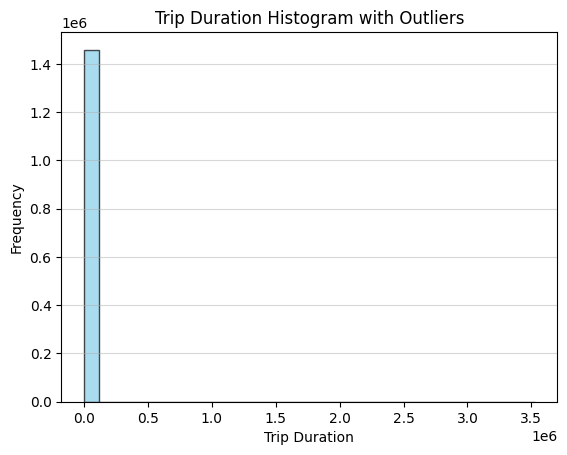

In [23]:
dfTaxi = pd.read_csv(path + 'train.csv', low_memory=False)
#print(dfTaxi.head(2))
print('Missing Taxi\n',dfTaxi.isnull().sum())
print("Shape\n",dfTaxi.shape)
dfTaxi['Distance'] = dfTaxi.apply(get_trip_distance, axis=1)
dfTaxi['Bearing'] = dfTaxi.apply(get_bearing, axis=1)
#dfTaxi['store_and_fwd_flag_int'] = dfTaxi.apply(store_and_fwd_flag_convert, axis=1)
dfTaxi[['day_index', 'hour', 'weekend' ,'rush_hour']] = dfTaxi.apply(get_time_features, axis=1, result_type='expand')
#print(dfTaxi.head(3))
dfTaxiProcessed = dfTaxi.drop(columns=['id','pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'])
print(dfTaxiProcessed.head(3))
dfTaxiProcessed.drop(columns=['vendor_id'], inplace=True)
dfTaxiProcessed.drop(columns=['passenger_count'], inplace=True)
#dfTaxiProcessed.drop(columns=['store_and_fwd_flag_int'], inplace=True)
dfTaxiProcessed.drop(columns=['pickup_longitude'], inplace=True)
dfTaxiProcessed.drop(columns=['pickup_latitude'], inplace=True)
dfTaxiProcessed.drop(columns=['dropoff_longitude'], inplace=True)
dfTaxiProcessed.drop(columns=['dropoff_latitude'], inplace=True)
#dfTaxiProcessed.drop(columns=['day_index'], inplace=True)
#dfTaxiProcessed.drop(columns=['hour'], inplace=True)
#dfTaxiProcessed.drop(columns=['weekend'], inplace=True)
#dfTaxiProcessed.drop(columns=['rush_hour'], inplace=True)
plt.hist(dfTaxiProcessed['trip_duration'].values, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Trip Duration Histogram with Outliers')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

Count of ouliers =  2073
   Distance     Bearing  day_index  hour  weekend  rush_hour  trip_duration
0  1.498521   99.970196          0    17        0          1            455
1  1.805507  242.846232          6     0        1          0            663
2  6.385098  200.319835          1    11        0          0           2124


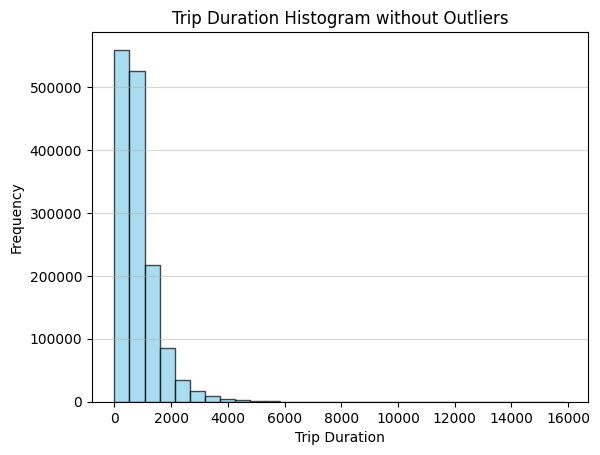

In [24]:
outlierIndices = get_outliers(dfTaxiProcessed['trip_duration'].values, 3)[0]
print('Count of ouliers = ', len(outlierIndices))
dfTaxiProcessedCleaned = dfTaxiProcessed.drop(outlierIndices, axis=0)
trip_duration = dfTaxiProcessedCleaned['trip_duration']
dfTaxiProcessedCleaned.drop(columns=['trip_duration'], inplace=True)
rowsize, columnsize = dfTaxiProcessedCleaned.shape
dfTaxiProcessedCleaned.insert(loc=columnsize, column='trip_duration', value=trip_duration)
print(dfTaxiProcessedCleaned.head(3))
plt.hist(dfTaxiProcessedCleaned['trip_duration'].values, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Trip Duration Histogram without Outliers')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
trainSplit, testSplit = train_test_split(dfTaxiProcessedCleaned, test_size=0.2, random_state=randomSeed)

DTrain = np.array(trainSplit)
DTest = np.array(testSplit)
DTrainS, mean, std = standardize_fit(DTrain)
DTestS = standardize_apply(DTest, mean, std)
print('shape of data = ', DTrainS.shape)
#print('Mean of data = ', mean)
#print('Standard Deviation of data = ', std)
#print('Mean of standardised data = ', DTrainS.mean(axis=0))
#DTrainS = DTrain
#DTestS = DTest

splitSize = 3
degree = 2
dataArr = np.array(DTrainS)
np.random.shuffle(dataArr)
cv = np.array_split(dataArr, splitSize, axis=0)
mseTemp = 0.0
r2Temp = 0.0
iterations = 4000
gdCoefficientsWTemp = np.zeros(generate_polynomial_features(dataArr[:, :-1][:2, :], degree).shape[1]+1)
gdLosses = np.zeros(iterations)
for i in range(splitSize):
    testData = cv[i]
    trainData = np.empty(shape=(0, dataArr.shape[1]))
    for j in range(splitSize):
        if(i==j):
            continue
        trainData = np.concatenate((trainData, cv[j]), axis=0)

    #gdCoefficientsW = fit_linear_gd_lasso(generate_polynomial_features(trainData[:, :-1], degree), trainData[:, -1], 1e1, 1e-4, iterations) #Uncomment for Gradient decent Lasso,comment me for SVR,GB_XGB, GB_LGM
    #gdCoefficientsW, gdLossesTemp = fit_linear_gd(generate_polynomial_features(trainData[:, :-1], degree), trainData[:, -1], 0.0, 1e-10, iterations) #Uncomment for Gradient decent Ridge,comment me for SVR,GB_XGB, GB_LGM
    #gdCoefficientsW = fit_linear_closed_form(generate_polynomial_features(trainData[:, :-1], degree), trainData[:, -1], 1e3) #Uncomment for Closed form, comment me for SVR,GB_XGB, GB_LGM
    #yHat = predict_linear(generate_polynomial_features(testData[:, :-1], degree), gdCoefficientsW) #comment me for SVR,GB_XGB, GB_LGM
    #gdCoefficientsWTemp += gdCoefficientsW #Uncomment for classical, comment me for SVR,GB_XGB, GB_LGM
    #gdLosses += gdLossesTemp #Uncomment for Ridge Gradient decent, comment me for SVR,GB_XGB, GB_LGM

    #mseTemp += mse(testData[:, -1], yHat) #comment me for SVR,GB_XGB, GB_LGM
    #r2Temp += r2_score(testData[:, -1], yHat) #comment me for SVR,GB_XGB, GB_LGM

print('Average training MSE = ', mseTemp/splitSize)
print('Average training R2 = ', r2Temp/splitSize)

#yHatTest = predict_linear(generate_polynomial_features(DTestS[:, :-1], degree), gdCoefficientsWTemp/splitSize) # linear, polynomila, ridge, lasso

yHatTest = svr(generate_polynomial_features(dataArr[:, :-1], degree), dataArr[:, -1], np.array(DTestS)[:, :-1]) # svr

#yHatTest = gb_xgb(generate_polynomial_features(dataArr[:, :-1], degree), dataArr[:, -1], np.array(DTestS)[:, :-1]) # gb_xgb

#yHatTest = gb_lgbm(generate_polynomial_features(dataArr[:, :-1], degree), dataArr[:, -1], np.array(DTestS)[:, :-1]) # gb_lgbm


test_mse = mse(DTestS[:, -1], yHatTest)
test_r2 = r2_score(DTestS[:, -1], yHatTest)

print('Test MSE = ', test_mse)
print('Test R2 = ', test_r2)

print('y ',DTestS[:, -1][:10])
print('yhat ',yHatTest[:10])

plt.plot(range(iterations), gdLosses/splitSize)
plt.title('Gradient Decent Loss Vs Iteration Number')
plt.xlabel('Ietrations')
plt.ylabel('Gradient Decent Loss')
plt.show()

shape of data =  (1165256, 7)
Average training MSE =  0.0
Average training R2 =  0.0
